# Monai test.

### Setup.

In [ ]:
import os
import torch
import matplotlib.pyplot as plt
from monai.bundle import ConfigParser, download
from monai.transforms import LoadImage, LoadImaged, Orientation, Orientationd, EnsureChannelFirst, EnsureChannelFirstd, Compose
from tcia_utils import nbia

# Consts.
model_name = "wholeBody_ct_segmentation"
download_model = False
data_dir = "./data"
# dicom_dir = os.path.join(data_dir, "1.3.6.1.4.1.14519.5.2.1.3320.3273.193828570195012288011029757668")
dicom_dir = os.path.join(data_dir, "dicom5")
model_path = os.path.join(data_dir, model_name, "models", "model.pt")
config_path = os.path.join(data_dir, model_name, "configs", "inference.json")
simulation_batch_size = 20

# Download CT data.
print("Downloading data")
cart_name = "nbia-56561691129779503"
cart_data = nbia.getSharedCart(cart_name)
df = nbia.downloadSeries(cart_data, format="df", path=data_dir)

# Download the model.
if download_model:
    print("Downloading model")
    download(name=model_name, bundle_dir=data_dir)

# Get config.
# Note: This block of code must occur after the model download block, otherwise config file will not be found.
config = ConfigParser()
config.read_config(config_path)

# Load the model.
print("Loading model")
torch.cuda.empty_cache()
model = config.get_parsed_content("network")
model.load_state_dict(torch.load(model_path))
model.cuda()
model.eval()

# Get inferer.
inferer = config.get_parsed_content("inferer")

# Preprocessor for visualization purposes.
visualization_preprocessing = Compose([
    LoadImaged(keys="image", image_only=True),
    EnsureChannelFirstd(keys="image"),
    Orientationd(keys="image",axcodes="RAS")
])

# Preprocessor.
preprocessing = config.get_parsed_content("preprocessing")

# Postprocessor.
postprocessing = config.get_parsed_content("postprocessing")

### Get the data.

In [4]:
# Visualization data.
visualization_data = {"image": dicom_dir}
visualization_data = visualization_preprocessing(visualization_data)

# Preprocessed data.
data = preprocessing({"image": dicom_dir})
data["image"] = data["image"].unsqueeze(0).cuda()  # Add batch dimension and move to GPU.

# Simulate larger batch size.
if simulation_batch_size is not None:
    data["image"] = data["image"].repeat(simulation_batch_size, 1, 1, 1, 1)

print(f"Image shape: {data['image'].shape}")

Image shape: torch.Size([20, 1, 169, 169, 124])


### Run segmentation.

In [6]:
with torch.no_grad():
    data["pred"] = inferer(data["image"], network=model)

print(f"Prediction shape: {data['pred'].shape}")

Prediction shape: torch.Size([20, 105, 169, 169, 124])


### Postprocessing

In [7]:
# Remove batch dimension and move to CPU.
data["image"] = data["image"][0].cpu()
data["pred"] = data["pred"][0].cpu()

# Postprocessing.
data = postprocessing(data)

# Get segmentation.
segmentation = torch.flip(data["pred"][0], dims=[2])
segmentation = segmentation.numpy()

2024-12-04 17:08:39,718 INFO image_writer.py:197 - writing: eval/dicom5/dicom5_trans.nii.gz


### Show results.

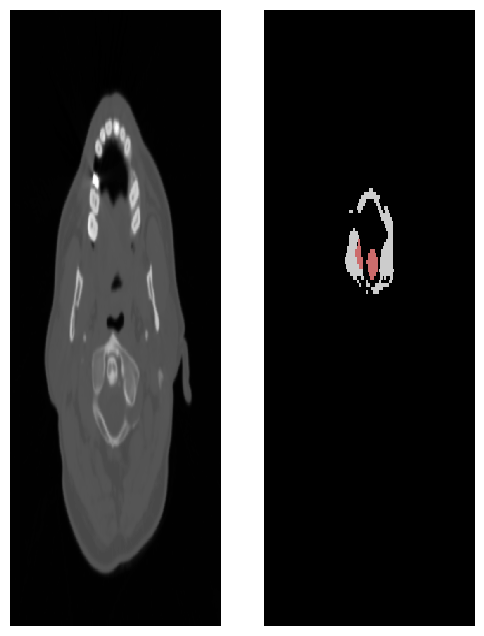

In [8]:
slice_index = 10
slice = visualization_data["image"][0, :, :, slice_index].numpy()
segmentation_slice = segmentation[:, :, slice_index]

plt.subplots(1,2,figsize=(6,8))
plt.subplot(121)
plt.pcolormesh(slice.T, cmap="Greys_r")
plt.axis("off")
plt.subplot(122)
plt.pcolormesh(segmentation_slice.T, cmap="nipy_spectral")
plt.axis("off")
plt.show()